<figure>
  <center><img style='height: 80%; width: 80%; object-fit: contain' src="../images/slot_machine.jpg" /></center>
  <center><figcaption>The k-armed bandit problem is as if you were playing multiple slot machines at once</figcaption></center>
</figure>

### **The k-armed bandit problem**

In reinforcement learning (RL), the primary distinction between RL and supervised learning (SL) is that RL *evaluates* the actions of the bot rather than *instructing* it. SL simply indicates the correct action to be taken, regardless of the action taken, while RL indicates how good the action was. To study the evaluative aspect of RL, we will consider a simplified setting called the k-armed bandit problem.

In this problem, you are faced repeatedly with a choice among k different actions. After each choice, you receive a numerical reward chosen from a stationary probability density function that depends on the action you selected. Your goal is to maximize the expected total reward over a specified time period, such as 1000 time steps. 

The problem is named after the analogy to a slot machine (the "one-armed bandit"), except that it has k levers. Each action has an expected reward, referred to as its **value**. It's important to note that if you knew the value of each action, the problem would be solved because you would simply select the action with the greatest value. In practice we need to estimate the value, which is formally defined as:

$$ q_{*}(a) := \mathbf{E}[R_{t}|A_{t}=a] $$

Where $q_{*}(a)$ is the expected reward, given that action $a$ is selected. $R_{t}$ is the reward and $A_{t}$ is the action taken at time $t$. The subscript $*$ indicates that this is the true value, which is unknown to the agent but it is the value we are trying to estimate. In theory, if we knew the [joint probability distribution]({filename}../probability/pdfs.ipynb) of the rewards and actions, we could calculate the true value of each action. However, in practice, we only have access to the historical rewards and actions, and we must estimate the true value of each action.

One way to estimate the values of actions is to average the rewards seen when a particular action was taken (not necessarily the best way). Formalizing this, we can define the action-value estimate as:

$$ Q_{t}(a) := \frac{\text{sum of rewards when $a$ taken prior to t}}{\text{number of times $a$ taken prior to t}} $$
$$ Q_{t}(a) = \frac{\sum_{i=1}^{t-1}R_{i}\cdot \boldsymbol{1}_{A_i=a}}{\sum_{i=1}^{t-1} \boldsymbol{1}_{A_{i}=a}} $$

Then, the simplest action selection rule is to choose the action with the highest estimated value, referred to as a greedy action.

$$A_{t} := \underset{a}{\mathrm{argmax}}Q_{t}(a) $$

 This method of estimating the value of an action, in addition to the action selection logic, is one example of an **action-value method**.

 In addition, it is often beneficial to also explore non-greedy actions by selecting a random action with a small $\epsilon$ probability, known as an $\epsilon-greedy$ method. This ensures that all actions are sampled an infinite number of times, allowing the estimate of the value to converge to the true value.

To compare the performance of greedy and epsilon-greedy methods, Sutton provides a toy problem in his book where he analyzes a set of 2000 randomly generated k-armed bandit problems with k=10. The true values of the actions are selected from a normal distribution, and the reward for each action is also a normal distribution with a mean equal to the true value of the action. The learning agent is progressed over 1000 steps, referred to as one run, and this process is repeated 2000 times to effectively evaluate different bandit problems.

<figure>
  <center><img style='max-width:100%; height:auto' src="../images/multiarmed_bandit.JPG" /></center>
  <center><figcaption>Essentially each action is a associated with a reward distribution whose mean is the value. The centers of these distributions randomly change for each run</figcaption></center>
</figure>

What we see from such a simulation is that in the case of noisy rewards, the epsilon-greedy method performed better than the greedy method because it was able to explore more actions and improve its chances of finding the optimal action (see below). If there were no noise, the greedy method would perform best because it would quickly find the optimal action and stick to it. Overall, the epsilon-greedy method seemed to be the more robust choice, performing well in both noisy and less noisy environments. It is important to carefully consider the trade-off between exploration and exploitation in RL to achieve optimal performance.

<figure>
  <center><img style='max-width:100%; height:auto' src="../images/bandit_sim.JPG" /></center>
  <center><figcaption>It's clear that a little bit of exploration leads to higher average rewards and a higher percentage of decisions going to the optimal value decision</figcaption></center>
</figure>

### **Computational Implementation**

In order to calculate action values in a computationally efficient manner, we will consider a simple derivation. Let $R_i$ denote the reward received after the $ith$ selection of a *particular action* and let $Q_n$ denote the estimate of its action value after having been selected $n-1$ times. The formula for $Q_n$ is $Q_n = (R_1 + R_2 + ... + R_{n-1})/(n-1)$. However, we don't need to perform this computation over and over again. We can use the following update rule: 

$$Q_{n+1} = Q_n + (1/n)[R_n - Q_n]$$ 

The beauty of this is that it requires only computer memory for $Q_n$ and $n$. This update rule, also known as **incremental averaging**, is common and takes the form of: 

$$\text{New Estimate = Old Estimate + Step Size[Target - Old Estimate]}$$ 

In this case, the $\text{Target}$ is the nth reward and $\text{Target - Old Estimate}$ is an error estimate. Note that the Step Size gets smaller with increasing actions of this type taken.

Putting together the concepts of exploration-exploition via $\epsilon$-greedy methods and incremental averaging, we can implement a python function for the k-armed bandit RL agent as follows:

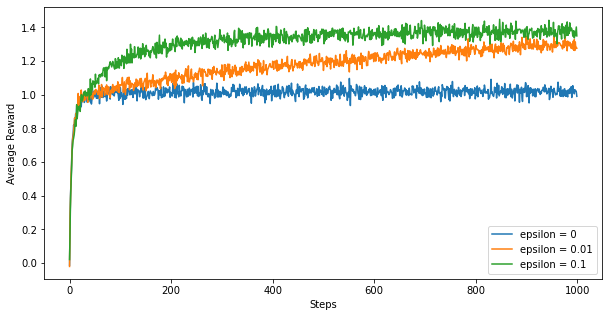

In [17]:
def k_armed_bandit(k, epsilon, runs, steps):
    # Initialize rewards to 0
    # This is used to store the rewards for each step
    # and then add them up for each run
    rewards = np.zeros(steps)
    # For each run
    for i in range(runs):
        # After each run, reset Q and N values
        # Initialize Q values to 0
        Q = np.zeros(k)
        # Initialize N values to 0
        N = np.zeros(k)
        # The "true" action values
        q = np.random.normal(loc=0, scale=1, size=k)
        # For each step
        for j in range(steps):
            # Select action based on epsilon greedy method
            if np.random.random() < epsilon:
                action = np.random.randint(k)
            else:
                action = np.argmax(Q)
            # Get reward from action
            reward = np.random.normal(loc=q[action])
            # Update N and Q values
            N[action] += 1
            Q[action] += (1/N[action])*(reward - Q[action])
            # Update rewards
            rewards[j] += reward
    # Return average rewards
    return rewards/runs

# lets now plot the average rewards for different values of epsilon
import matplotlib.pyplot as plt
import numpy as np
epsilons = [0, 0.01, 0.1]
runs = 2000
steps = 1000
k = 10
plt.figure(figsize=(10, 5))
for epsilon in epsilons:
    rewards = k_armed_bandit(k, epsilon, runs, steps)
    plt.plot(rewards, label='epsilon = ' + str(epsilon))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()
plt.show()


We arrive at the same results as sutton's textbook, which is a good sign that our implementation is correct.

### **Nonstationarity, Optimism and Upper Confidence Bound**

What if the reward distributions depicted above were not stationary? When reward probabilities change over time, it makes sense to give more weight to recent rewards. It's common to modify the step size parameter to be constant for non-stationary reward probability density functions. In this case, $Q_{n+1}$ becomes a weighted average of the past rewards, and is actually an **exponentially weighted average**! For the constant $\alpha$ case, the value function estimates actually never converge for large n, but this is what we want in non-stationary problems. It can be shown that the value function then takes the form:

$$Q_{n+1} = Q_n + \alpha[R_n - Q_n]$$
$$=> Q_{n+1} = (1-\alpha)Q_n + \alpha R_n$$
$$=> Q_{n+1} = \alpha R_n + (1-\alpha)\alpha R_{n-1} + (1-\alpha)^2\alpha R_{n-2} + ... + (1-\alpha)^{n-1}\alpha R_{1} + (1-\alpha)^{n}Q_{1}$$
$$=> Q_{n+1} = (1-\alpha)^{n}Q_1 + \alpha \sum_{i=1}^{n}(1-\alpha)^{n-i}R_i$$
where $\alpha$ is a constant step size parameter. 

The methods above depend on the initial action-value estimates, $Q_{1}(a)$. This is known as a biased estimate in statistics. For the sample-average method, the bias disappears once all actions have been selected at least once. But for a constant α, they persist. An initial bias in the value function, such as 5 in the k-armed bandit problem, is overly optimistic. But this over-optimism causes the algorithm to initially explore as it is disappointed in the rewards it is receiving. These **optimistic initial values are good for encouraging exploration** in stationary problems but not so in non-stationary problems since the exploration is only temporary in the beginning of the run.

Exploration is needed because what may seem like a valuable action at the beginning of the run may not be so valuable in the long run. The $\epsilon$-greedy methods encourage exploration of non-greedy actions but they do not take into account the uncertainty in the estimate of the action values. We can give preference to those actions which have some uncertainty and are close to being maximal. This can be captured with the following: 

$$A_{t} := \underset{a}{\mathrm{argmax}}[Q_{t}(a) + c\sqrt{\frac{\ln(t)}{N_{t}(a)}}]$$

where $c$ is a constant and $N_{t}(a)$ is the number of times action $a$ has been selected up to time $t$. This is known as the **upper confidence bound action selection**. The quantity being indexed is essentially the upper bound of that action's value. As $N_{t}(a)$ increases, i.e. you've observed that action more, the uncertainty in its value decreases. The problem with this method is that it is impractical for real non-stationary problems and large state spaces.

### **Conclusion**

In this post, we have covered the basics of reinforcement learning and the k-armed bandit problem. The problem describes a situation where an agent has to choose between k actions and each action has a different reward distribution. The agent has to learn which action is the best to maximize its long term reward, or value. In order to do this, it must estimate the value of each action by using an action value estimation method and it must also balance exploration and exploitation in its action-taking process. We examined various action value methods including the sample-average method and the constant step size method and how they can be used to solve stationary and non-stationary problems. Specifically, the constant step size method is useful in non-stationary problems where the reward distributions change over time. We also looked at the optimistic initial values method, where we can encourage more exploration, and the upper confidence bound action selection method where we can give preference to actions with less uncertainty. Most importantly, we have also seen how to implement a $\epsilon$-greedy RL agent with incremental averaging in a k-armed bandit setting using python.

### **Sources**

Sutton, R. S., Barto, A. G. (2018). Reinforcement learning: An introduction (2nd ed.). MIT Press Ltd. 

White, M., White, A. (n.d.). *Reinforcement Learning Specialization* [MOOC]. Coursera.